In [1]:
import os
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
os.getcwd()

'D:\\university\\face-emotions-recognition\\Labs'

In [3]:
os.chdir('D:\\university\\face-emotions-recognition')

In [4]:
root_dir = os.getcwd()
root_dir

'D:\\university\\face-emotions-recognition'

In [5]:
data_dir = os.path.join(root_dir, 'Data')
data_path = os.path.join(data_dir, 'fer2013.csv')

In [6]:
raw_data = pd.read_csv(data_path, index_col=False)

In [7]:
raw_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [9]:
label_to_index = {label: i for i, label in enumerate(emotion_labels)}

In [10]:
image_size = int(sqrt(len(raw_data.pixels[0].split()))) 

In [11]:
print(f'image dimensions: {image_size} x {image_size}')

image dimensions: 48 x 48


In [12]:
selected_emotions = ["Happy", "Sad", "Neutral"]

In [13]:
data = raw_data[raw_data['emotion'].apply(lambda emotion_idx: emotion_labels[emotion_idx] in selected_emotions)].reset_index(drop=True)

In [14]:
emotion_to_index = {label: i for i, label in enumerate(selected_emotions)}

In [15]:
for emotion in selected_emotions:
    data['emotion'] = data['emotion'].replace(to_replace=label_to_index.get(emotion), value=emotion)

In [16]:
data

,emotion,pixels,Usage
0,Sad,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
1,Neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
2,Sad,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
3,Happy,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
4,Happy,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
...,...,...,...
21259,Neutral,139 143 145 154 159 168 176 181 190 191 195 19...,PrivateTest
21260,Happy,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...,PrivateTest
21261,Neutral,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
21262,Happy,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest


In [17]:
data['emotion'].value_counts()

Happy      8989
Neutral    6198
Sad        6077
Name: emotion, dtype: int64

In [18]:
def str_to_image(string: str):
    pixels = np.array([float(pixel) for pixel in string.split()])
    pixels = pixels.reshape((image_size, image_size))
    return pixels

In [19]:
y = np.array(data['emotion'].apply(emotion_to_index.get))

In [20]:
x = np.array(list(data['pixels'].apply(str_to_image)))
x = x[:,:,:, np.newaxis]

In [21]:
x.shape

(21264, 48, 48, 1)

In [22]:
y.shape

(21264,)

In [23]:
data_split_dict = data['Usage'].value_counts().to_dict()
data_split_dict

{'Training': 17010, 'PublicTest': 2155, 'PrivateTest': 2099}

In [24]:
x_train = x[:data_split_dict.get('Training')]
x_val = x[data_split_dict.get('Training'):data_split_dict.get('Training') + data_split_dict.get('PublicTest')]
x_test = x[data_split_dict.get('Training') + data_split_dict.get('PublicTest'):]

In [25]:
y_train = y[:data_split_dict.get('Training')]
y_val = y[data_split_dict.get('Training'):data_split_dict.get('Training') + data_split_dict.get('PublicTest')]
y_test = y[data_split_dict.get('Training') + data_split_dict.get('PublicTest'):]

In [26]:
tf.keras.backend.clear_session()

In [27]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(len(selected_emotions), activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [28]:
model = build_model()

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [30]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=32, epochs=100, callbacks=[early_stopping])

Epoch 1/100
532/532 [==============================] - 5s 6ms/step - loss: 1.0698 - accuracy: 0.4350 - val_loss: 1.0432 - val_accuracy: 0.4733
Epoch 2/100
532/532 [==============================] - 3s 5ms/step - loss: 1.0288 - accuracy: 0.4800 - val_loss: 1.0223 - val_accuracy: 0.4882
Epoch 3/100
532/532 [==============================] - 3s 5ms/step - loss: 1.0048 - accuracy: 0.4955 - val_loss: 0.9956 - val_accuracy: 0.4863
Epoch 4/100
532/532 [==============================] - 3s 5ms/step - loss: 0.9981 - accuracy: 0.4947 - val_loss: 1.0009 - val_accuracy: 0.4710
Epoch 5/100
532/532 [==============================] - 3s 5ms/step - loss: 0.9931 - accuracy: 0.4970 - val_loss: 0.9834 - val_accuracy: 0.4900
Epoch 6/100
532/532 [==============================] - 3s 5ms/step - loss: 0.9864 - accuracy: 0.5015 - val_loss: 0.9807 - val_accuracy: 0.4877
Epoch 7/100
532/532 [==============================] - 3s 5ms/step - loss: 0.9849 - accuracy: 0.5035 - val_loss: 0.9788 - val_accuracy: 0.4891

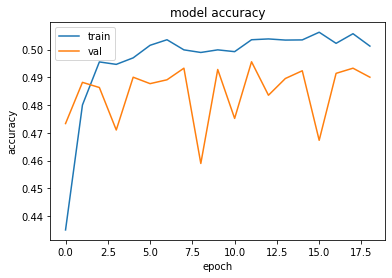

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

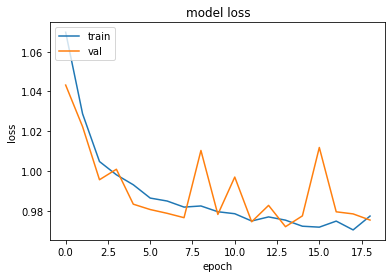

In [32]:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()